In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import matplotlib.image as mpimg

import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import mnist
np.random.seed(25)
tf.executing_eagerly()
from sklearn.model_selection import train_test_split

In [2]:
import zipfile 
zip_ref = zipfile.ZipFile('/content/Flower.zip')
zip_ref.extractall('/content')
zip_ref.close()

In [3]:
from sklearn.model_selection import train_test_split
datadir = '/content/Flower'
# Size of the image required to train our model
img_size = 128

# These many images will be used from the data archive
dataset_split = 120


data= []
for image_file in os.listdir( datadir )[ 0 : dataset_split ]:
    rgb_image = Image.open( os.path.join( datadir , image_file ) ).resize( ( img_size , img_size ) )
    # Normalize the RGB image array
    rgb_img_array = (np.asarray( rgb_image ) ) / 255
    data.append( rgb_img_array )

In [4]:
print(np.shape(data))

(108, 128, 128, 3)


In [5]:
X = np.array(data)

In [6]:
def Sampling(x):
    mu, sigma = x
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch,dim))
    return mu + K.exp(sigma/2)*eps

In [7]:
img_height   = X.shape[1]    # 128
img_width    = X.shape[2]    # 128
num_channels = X.shape[3]      # 3
input_shape =  (img_height, img_width, num_channels)   # (128,128,3)
latent_dim = 10   # Dimension of the latent space


encoder_input = Input(shape=input_shape)

encoder_conv = Conv2D(filters=8, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder_conv = Conv2D(filters=16, kernel_size=3, strides=2, 
                padding='same', activation='relu')(encoder_input)
encoder = Flatten()(encoder_conv)

mu = Dense(latent_dim)(encoder)
sigma = Dense(latent_dim)(encoder)

In [8]:
latent_space = Lambda(Sampling, output_shape=(latent_dim,))([mu, sigma])

In [9]:
conv_shape = K.int_shape(encoder_conv)

In [10]:
decoder_input = Input(shape=(latent_dim,))
decoder = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
decoder = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(decoder)
decoder_conv = Conv2DTranspose(filters=16, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv = Conv2DTranspose(filters=8, kernel_size=3, strides=2, 
                           padding='same', activation='relu')(decoder)
decoder_conv =  Conv2DTranspose(filters=num_channels, kernel_size=3, 
                          padding='same', activation='sigmoid')(decoder_conv)

In [11]:
encoder = Model(encoder_input, latent_space)
decoder = Model(decoder_input, decoder_conv)
vae = Model(encoder_input, decoder(encoder(encoder_input)))

In [12]:
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss
    return K.mean(reconstruction_loss + kl_loss)

In [13]:
vae.compile(optimizer='adam', loss=kl_reconstruction_loss)

In [14]:
history = vae.fit(x=X, y=X, epochs=50, batch_size=20)

Train on 108 samples
Epoch 1/50
108/108 [==============================] - 4s 34ms/sample - loss: 11879.2534
Epoch 2/50
108/108 [==============================] - 3s 27ms/sample - loss: 11431.9270
Epoch 3/50
108/108 [==============================] - 3s 30ms/sample - loss: 11422.1032
Epoch 4/50
108/108 [==============================] - 3s 27ms/sample - loss: 11404.6177
Epoch 5/50
108/108 [==============================] - 3s 28ms/sample - loss: 11387.1078
Epoch 6/50
108/108 [==============================] - 3s 29ms/sample - loss: 11351.5412
Epoch 7/50
108/108 [==============================] - 3s 24ms/sample - loss: 11290.1333
Epoch 8/50
108/108 [==============================] - 2s 15ms/sample - loss: 11152.7004
Epoch 9/50
108/108 [==============================] - 2s 15ms/sample - loss: 10948.6491
Epoch 10/50
108/108 [==============================] - 2s 15ms/sample - loss: 10806.4830
Epoch 11/50
108/108 [==============================] - 2s 15ms/sample - loss: 10832.7679
Epoch 12/

In [15]:
encoded = encoder.predict(X)
print(np.shape(encoded))

(108, 10)


/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [16]:
def display_image_sequence(no_of_imgs, latent_space):
      my_list = []
      for s in range(1, latent_space+1):
          new_axis = np.linspace(np.random.randint(-s, s), np.random.randint(-s, s), no_of_imgs)
          new_axis = new_axis[:, np.newaxis]
          my_list.append(list(new_axis))

      new_points = np.hstack(my_list)
      new_images = decoder.predict(new_points)
      new_images = new_images.reshape(no_of_imgs, 128, 128, 3)
      
      # Display some images
      fig, axes = plt.subplots(ncols=no_of_imgs, sharex=False,
                              sharey=True, figsize=(20, 7))
      counter = 0
      for i in range(no_of_imgs):
          axes[counter].imshow(new_images[i])
          axes[counter].get_xaxis().set_visible(False)
          axes[counter].get_yaxis().set_visible(False)
          counter += 1
      plt.show()

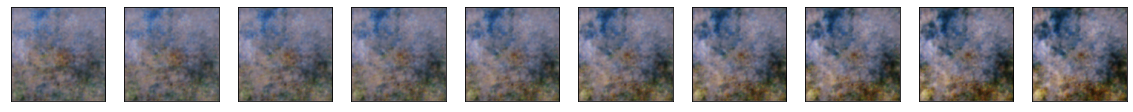

In [17]:
display_image_sequence(10,10)

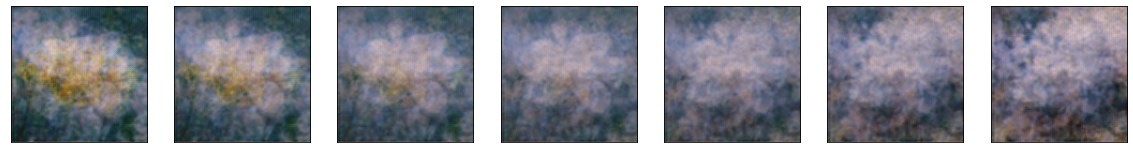

In [18]:
number_of_images = 7 #@param {type:"slider", min:0, max:12, step:1}

display_image_sequence(number_of_images,10)